In [95]:
import pandas as pd
passenger_train=pd.read_csv('train.csv')
target_col='Survived'
id_col='PassengerId'
target=passenger_train[target_col]
total_num=len(passenger_train)

In [96]:
# drop useless cols
c=passenger_train.count()
drop_cols=c[c*2<len(passenger_train)].index
drop_cols=list(drop_cols)
drop_cols+=[id_col,target_col,'Name','Ticket']
passenger_train.drop(drop_cols,axis=1,inplace=True)

In [3]:
passenger_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


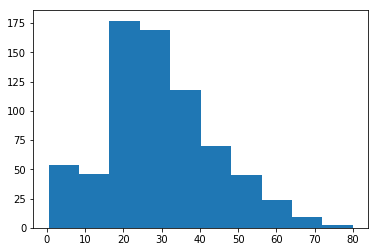

In [4]:
%matplotlib inline
from matplotlib import pyplot

pyplot.hist(passenger_train['Age'].dropna())
pyplot.show()

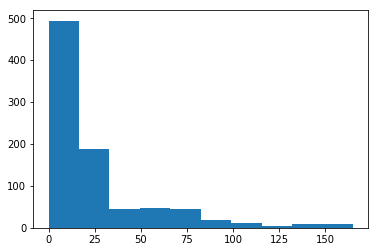

In [5]:
%matplotlib inline
from matplotlib import pyplot

pyplot.hist(passenger_train[passenger_train['Fare']<200]['Fare'].dropna())
pyplot.show()

In [97]:
import sys
sys.path.append('../')
from util import *

In [63]:
passenger_train[passenger_train['Fare']==0.0]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
179,3,male,36.0,0,0,0.0,S
263,1,male,40.0,0,0,0.0,S
271,3,male,25.0,0,0,0.0,S
277,2,male,NaN,0,0,0.0,S
302,3,male,19.0,0,0,0.0,S
413,2,male,NaN,0,0,0.0,S
466,2,male,NaN,0,0,0.0,S
481,2,male,NaN,0,0,0.0,S
597,3,male,49.0,0,0,0.0,S
633,1,male,NaN,0,0,0.0,S


In [98]:
from sklearn.preprocessing import Imputer, StandardScaler, LabelBinarizer,LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion

summary=passenger_train.describe()
num_imputer=Imputer(strategy='median')

num_pl=Pipeline([
    ('select',DataFrameSelecter(summary.columns)),
    ('fill',Imputer(strategy='median')),
    ('scale',StandardScaler()),
])
num_pl.fit(passenger_train)

cat_cols=list(set(passenger_train.columns)-set(summary.columns))
pls=[Pipeline([
    ('select',DataFrameSelecter2(c)),
    ('drop',NanDropper()),
    ('encode',LabelBinarizer()),
]) for c in cat_cols ]

[pls[i].fit_transform(passenger_train) for i in range(len(cat_cols))]

cat_pls=[(cat_cols[i],Pipeline([
    ('select',DataFrameSelecter3(cat_cols[i])),
    ('encode',pls[i].named_steps['encode']),
])) for i in range(len(cat_cols))]

full_pl=FeatureUnion(transformer_list=[('num',num_pl)]+cat_pls)

prepared_passenger_train_data=full_pl.transform(passenger_train)

# add new cat cols
new_cat_cols=[]
g=lambda i,c: '%s_%s'%(cat_cols[i],c) if len(pls[i].named_steps['encode'].classes_)>2 else None
for i in range(len(cat_cols)):
    for c in pls[i].named_steps['encode'].classes_:
        if len(pls[i].named_steps['encode'].classes_)>2:
            new_cat_cols.append('%s_%s'%(cat_cols[i],c))
        else:
            if cat_cols[i] not in new_cat_cols:
                new_cat_cols.append(cat_cols[i])
new_cat_cols

# delete origin cat cols
cols=list(passenger_train.columns)
[cols.remove(c) for c in cat_cols]

# build new df
prepared_passenger_train=pd.DataFrame(prepared_passenger_train_data,columns=cols+new_cat_cols)
prepared_passenger_train.head()


,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked_C,Embarked_Q,Embarked_S
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,1.0,0.0,0.0,1.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.0,1.0,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.0,0.0,0.0,1.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.0,0.0,0.0,1.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,1.0,0.0,0.0,1.0


In [8]:
passenger_test=pd.read_csv('test.csv')
test_id=passenger_test[id_col]
drop_cols.remove(target_col)
passenger_test.drop(drop_cols,axis=1,inplace=True)
prepared_passenger_test=full_pl.transform(passenger_test)

## gradient boosting tree

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()

from sklearn.model_selection import cross_val_score

scores=cross_val_score(gbc,prepared_passenger_train,target,scoring='accuracy',cv=10)
scores.mean()


0.83395386448757236

In [67]:
help(gbc)

Help on GradientBoostingClassifier in module sklearn.ensemble.gradient_boosting object:

class GradientBoostingClassifier(BaseGradientBoosting, sklearn.base.ClassifierMixin)
 |  Gradient Boosting for classification.
 |  
 |  GB builds an additive model in a
 |  forward stage-wise fashion; it allows for the optimization of
 |  arbitrary differentiable loss functions. In each stage ``n_classes_``
 |  regression trees are fit on the negative gradient of the
 |  binomial or multinomial deviance loss function. Binary classification
 |  is a special case where only a single regression tree is induced.
 |  
 |  Read more in the :ref:`User Guide <gradient_boosting>`.
 |  
 |  Parameters
 |  ----------
 |  loss : {'deviance', 'exponential'}, optional (default='deviance')
 |      loss function to be optimized. 'deviance' refers to
 |      deviance (= logistic regression) for classification
 |      with probabilistic outputs. For loss 'exponential' gradient
 |      boosting recovers the AdaBoost 

0.901236419844 0.833953864488


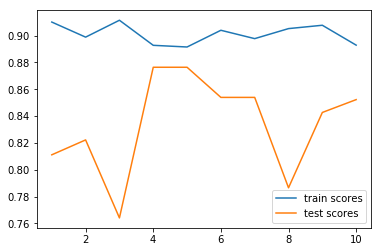

In [101]:
from sklearn.model_selection import validation_curve

train_scores,test_scores=validation_curve(gbc,prepared_passenger_train,target,
                                          scoring='accuracy',param_name='learning_rate',param_range=[0.1],cv=10)
print(train_scores.mean(), test_scores.mean())
plotValidationCurve(train_scores,test_scores)

In [51]:
survived=clf.predict(prepared_passenger_test)
df=pd.DataFrame({id_col:test_id,target_col:survived})
df.to_csv('result.csv',index=False)

kaggle score:0.78469 rank: 3086

In [10]:
import time
time.time()

1500802274.9865792

### tune params

In [11]:
# from sklearn.model_selection import GridSearchCV
# t1=time.time()
# param_grid={'max_depth':[2,3,5,8],'n_estimators':[50,100,150],'learning_rate':[0.1,0.01]}
# clf=GridSearchCV(GradientBoostingClassifier(),param_grid,scoring='accuracy',cv=10,n_jobs=4)
# clf.fit(prepared_passenger_train,target)
# print(clf.best_score_,clf.best_params_,time.time()-t1)

In [12]:
# survived=clf.predict(prepared_passenger_test)
# df=pd.DataFrame({id_col:test_id,target_col:survived})
# df.to_csv('result.csv',index=False)

kaggle score:0.78469 rank: 3073

## random forest

In [99]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()

from sklearn.model_selection import cross_val_score

scores=cross_val_score(rfc,prepared_passenger_train,target,scoring='accuracy',cv=10)
scores.mean()



0.80932215412552488

In [69]:
help(rfc)

Help on RandomForestClassifier in module sklearn.ensemble.forest object:

class RandomForestClassifier(ForestClassifier)
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and use averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |      Note: this parameter is tree-specific.
 |  
 |  max_features : int, f

### tune params

In [115]:
from sklearn.model_selection import GridSearchCV

params={'n_estimators':[10,30,50,100],'max_features':[4,6,8],'max_depth':[4,8,16]}
gs=GridSearchCV(RandomForestClassifier(),params,scoring='accuracy',cv=10,n_jobs=-1)
gs.fit(prepared_passenger_train,target)
rfc=gs.best_estimator_
print(gs.best_score_,gs.best_params_)

0.840628507295 {'max_depth': 8, 'n_estimators': 100, 'max_features': 4}


0.91558885724 0.835082345191


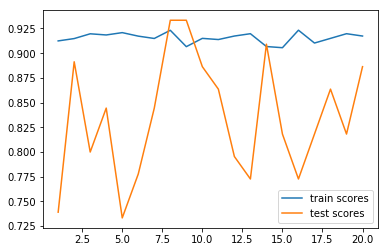

In [116]:
from sklearn.model_selection import validation_curve

train_scores,test_scores=validation_curve(rfc,prepared_passenger_train,target,
                                          scoring='accuracy',param_name='n_estimators',param_range=[50],cv=20)
print(train_scores.mean(), test_scores.mean())
plotValidationCurve(train_scores,test_scores)

In [117]:
feature_scores=zip( rfc.feature_importances_,prepared_passenger_train.columns)
np.sort(list(feature_scores),0)

array([['0.00940756263707', 'Age'],
       ['0.0129275158898', 'Embarked_C'],
       ['0.0165567832664', 'Embarked_Q'],
       ['0.0300754496281', 'Embarked_S'],
       ['0.051552165427', 'Fare'],
       ['0.119920705611', 'Parch'],
       ['0.180544347127', 'Pclass'],
       ['0.211367927865', 'Sex'],
       ['0.367647542548', 'SibSp']], 
      dtype='<U32')

In [119]:
survived=rfc.predict(prepared_passenger_test)
df=pd.DataFrame({id_col:test_id,target_col:survived})
df.to_csv('result.csv',index=False)

kaggle score:0.79904 rank: 1381

## SVM

In [14]:
from sklearn.svm import SVC
# clf=LinearSVC(C=1,loss='hinge')
svc=SVC(kernel='poly',probability=True)

from sklearn.model_selection import cross_val_score
scores=cross_val_score(svc,prepared_passenger_train,target,scoring='accuracy',cv=10)
scores.mean()

0.78467767563273172

## draw validation curve

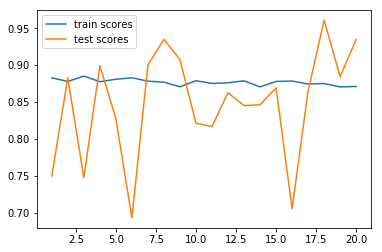

In [65]:
from sklearn.model_selection import validation_curve

train_scores,test_scores=validation_curve(svc,prepared_passenger_train,target,scoring='roc_auc',param_name='C',param_range=[1],cv=20)
plotValidationCurve(train_scores,test_scores)

In [64]:
%matplotlib inline
def plotValidationCurve(train_scores,test_scores):
    from matplotlib import pyplot

    xaxis=[i for i in range(1,len(train_scores[0])+1)]
    pyplot.plot(xaxis,train_scores[0],label='train scores')
    pyplot.plot(xaxis,test_scores[0],label='test scores')
    pyplot.legend()
    pyplot.show()

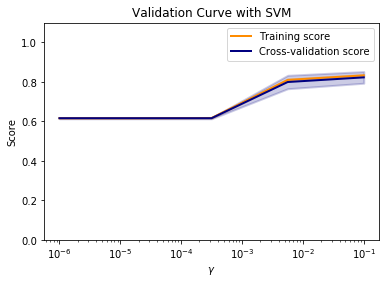

In [17]:
import matplotlib.pyplot as plt
param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), prepared_passenger_train, target, param_name="gamma", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

use ensemble methods

In [18]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

vote=VotingClassifier(estimators=[('gbc',gbc),('rfc',rfc),('svc',svc)],voting='soft')
scores=cross_val_score(vote,prepared_passenger_train,target,scoring='accuracy',cv=10)
scores.mean()

0.82270514130064698

## stacking

In [38]:
from brew.base import Ensemble, EnsembleClassifier
from brew.stacking.stacker import EnsembleStack, EnsembleStackClassifier
from brew.combination.combiner import Combiner

# Creating Ensemble
ensemble = Ensemble([gbc, rfc, svc])
eclf = EnsembleClassifier(ensemble=ensemble, combiner=Combiner('mean'))

# from sklearn.model_selection import cross_val_score
# scores=cross_val_score(eclf,prepared_passenger_train,target,scoring='accuracy',cv=10)
eclf.fit(prepared_passenger_train,target)
eclf.score(prepared_passenger_train,target)

0.9135802469135802

In [52]:
survived=eclf.predict(prepared_passenger_test)
survived=[int(s) for s in survived]
df=pd.DataFrame({id_col:test_id,target_col:survived})
df.to_csv('result.csv',index=False)

not better

In [58]:
# Creating Stacking
layer_1 = Ensemble([gbc, rfc, svc])
layer_2 = Ensemble([sklearn.clone(gbc)])

stack = EnsembleStack(cv=3)

stack.add_layer(layer_1)
stack.add_layer(layer_2)

sclf = EnsembleStackClassifier(stack)
sclf.fit(prepared_passenger_train_data,target)

survived=sclf.predict(prepared_passenger_test)
survived=[int(s) for s in survived]
df=pd.DataFrame({id_col:test_id,target_col:survived})
df.to_csv('result.csv',index=False)

not better

## xgboost

In [61]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

xgb=XGBClassifier()
scores=cross_val_score(xgb,prepared_passenger_train,target,scoring='accuracy',cv=10)
scores.mean()

0.82276756327318135